# Data Analyst Professional Practical Exam Submission

**You can use any tool that you want to do your analysis and create visualizations. Use this template to write up your summary for submission.**

You can use any markdown formatting you wish. If you are not familiar with Markdown, read the [Markdown Guide](https://s3.amazonaws.com/talent-assets.datacamp.com/Markdown+Guide.pdf) before you start.


## 📝 Task List

Your written report should include written text summaries and graphics of the following:
- Data validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Definition of a metric for the business to monitor  
  - How should the business use the metric to monitor the business problem
  - Can you estimate initial value(s) for the metric based on the current data
- Final summary including recommendations that the business should undertake

*Start writing report here..*

Importing the data and viewing it

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('product_sales.csv')

data.head()

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,NaN,0,24,Arizona
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,NaN,3,25,Indiana
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois


Checking the existing values and datatypes. All types match instructions.

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   week               15000 non-null  int64  
 1   sales_method       15000 non-null  object 
 2   customer_id        15000 non-null  object 
 3   nb_sold            15000 non-null  int64  
 4   revenue            13926 non-null  float64
 5   years_as_customer  15000 non-null  int64  
 6   nb_site_visits     15000 non-null  int64  
 7   state              15000 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 937.6+ KB


Further check on null values. 'Revenue' -column seems to have many, others are full.

In [3]:
data.isna().sum()

week                    0
sales_method            0
customer_id             0
nb_sold                 0
revenue              1074
years_as_customer       0
nb_site_visits          0
state                   0
dtype: int64

Checking the values of 'week' column. All seems to be logical.

In [4]:
data['week'].value_counts()

1    3721
4    2575
5    2574
2    2491
3    2411
6    1228
Name: week, dtype: int64

Checking the 'sales_method' column. Some values are entered wrong, but its pretty obvious in which categories they belong. 
'email' and 'em + call' values will be replaced with .loc technique.
Now we have three different sales methods, as instructed.

In [5]:
data['sales_method'].value_counts()

Email           7456
Call            4962
Email + Call    2549
em + call         23
email             10
Name: sales_method, dtype: int64

In [6]:
data.loc[data['sales_method'] == 'email', 'sales_method'] = 'Email'
data.loc[data['sales_method'] == 'em + call', 'sales_method'] = 'Email + Call'
data['sales_method'].value_counts()

Email           7466
Call            4962
Email + Call    2572
Name: sales_method, dtype: int64

'customer_id' column has 15000 unique values, no nulls as checked above.

In [7]:
data['customer_id'].duplicated().value_counts()

False    15000
Name: customer_id, dtype: int64

Checking the 'nb_sold' column. 15 000 non-negative and non-null values detected.

In [8]:
print(data['nb_sold'].max())
print(data['nb_sold'].min())
data['nb_sold'].info()

16
7
<class 'pandas.core.series.Series'>
RangeIndex: 15000 entries, 0 to 14999
Series name: nb_sold
Non-Null Count  Dtype
--------------  -----
15000 non-null  int64
dtypes: int64(1)
memory usage: 117.3 KB


Checking the 'revenue' column. We know there are missing values, I will also check the range.

The proportion of null values in the revenue column is over 5 %, must be imputed instead of dropping. 

In [9]:
print('max: ', data['revenue'].max())
print('min: ', data['revenue'].min())
pc_null_revenues = data['revenue'].isna().sum() / len(data)
print('Proportion of nulls: ', pc_null_revenues)
print('Greater than 5%: ', pc_null_revenues > 0.05)

max:  238.32
min:  32.54
Proportion of nulls:  0.0716
Greater than 5%:  True


Scatterplot below shows that there is not only a relationship between the revenue and sales method, but also a linear one  with the number of products sold.

I must take it into account to get as accurate as possible estimations for the missing revenues.

<AxesSubplot: xlabel='nb_sold', ylabel='revenue'>

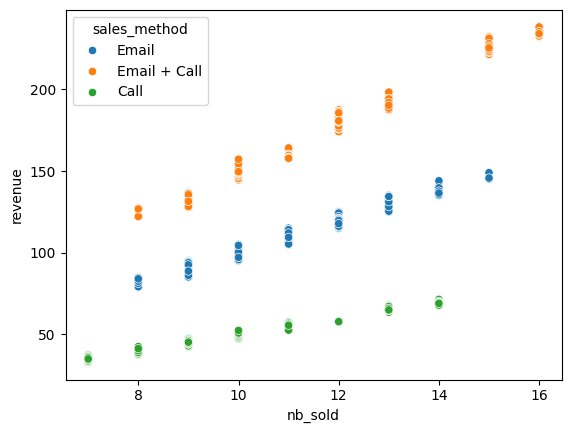

In [10]:
sns.scatterplot(x='nb_sold', y='revenue', data=data, hue='sales_method')

Let's create a temporary column to count the revenue per single product sold.

I'll fill the null-values with grouped average revenue per product by sales method. 

Counting the AVGs:

In [11]:
data['rev_by_unit'] = data['revenue'] / data['nb_sold']
avg_revenues_by_method = data.groupby('sales_method')['rev_by_unit'].mean()
avg_revenues_by_method 

sales_method
Call             5.013634
Email           10.001970
Email + Call    15.074874
Name: rev_by_unit, dtype: float64

Null values are filled with .map method to the temporary column 'rev_by_unit'

'revenue' column is then updated back by: 'rev_by_unit' * 'nb_sold'
Temporary column 'rev_by_unit' is then removed.
Column description shows that there are now 15000 non-null values in the 'revenue' column.

In [12]:
data['rev_by_unit'] = data['rev_by_unit'].fillna(data['sales_method'].map(avg_revenues_by_method))
data['revenue'] = round(data['rev_by_unit'] * data['nb_sold'], 2)
data.drop('rev_by_unit', axis=1, inplace=True)
data['revenue'].describe()

count    15000.000000
mean        95.731264
std         48.395776
min         32.540000
25%         52.760000
50%         90.020000
75%        108.630000
max        241.200000
Name: revenue, dtype: float64

Moving to 'years_as_customer' column

The year is now 2024 and the company was founded in 1984. We see there are two rows exceeding the limit of 40 years.

I'll replace them with the maximum possible value of 40. Also checking wether there are values below zero before declaring the column clean.

Check of 'years_as_customer':

No null values detected above
Values over 40 replaced with 40
All rows remain, range is logical.

In [13]:
data[data['years_as_customer'] > 40]

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
13741,2,Email,18919515-a618-430c-9a05-2c7d8fea96af,10,97.22,63,24,California
13800,4,Call,2ea97d34-571d-4e1b-95be-fea1c404649f,10,50.47,47,27,California


In [14]:
data.loc[data['years_as_customer'] > 40, 'years_as_customer'] = 40

In [15]:
print(data['years_as_customer'].describe())

count    15000.000000
mean         4.963933
std          5.027211
min          0.000000
25%          1.000000
50%          3.000000
75%          7.000000
max         40.000000
Name: years_as_customer, dtype: float64


'nb_site_visits' column
Range is logical and non-missing as checked in the beginning.

In [16]:
print(data['nb_site_visits'].describe())

count    15000.000000
mean        24.990867
std          3.500914
min         12.000000
25%         23.000000
50%         25.000000
75%         27.000000
max         41.000000
Name: nb_site_visits, dtype: float64


All seems to be ok in the 'state' column. 15 000 non-null values, 50 different states.

In [17]:
print(data['state'].value_counts().info())
print(len(data['state']))

<class 'pandas.core.series.Series'>
Index: 50 entries, California to Vermont
Series name: state
Non-Null Count  Dtype
--------------  -----
50 non-null     int64
dtypes: int64(1)
memory usage: 800.0+ bytes
None
15000


Checking duplicate rows, no identical records.

In [18]:
data.duplicated().value_counts()

False    15000
dtype: int64

Data is cleaned and validated

Operations:
-'week' column has 15000 non-null and non-negative numeric values, as expected

-'sales_method' had 15000 non-null character values in 5 different categoriess, fixed into having three categories, as instructed

-'customer_id' has 15000 unique character values, as expected

-'nb_sold' has 15000 non-null and non-negative numeric values, as expected

-'revenue' had 1074 missing numeric values. Filled with the mean of each sale method group, weighted by 'nb_sold'. Updated column has 15000 non-null values as expected.

-'years_as_customer' column has 15000 non-null and non-negative numeric values. Two values above 40 converted to 40.

-'nb_site_visits' has 15000 non-null and non-negative numeric values, as expected.

-'state' column has 15000 non-null character values with 50 unique groups representing a state, as expected.

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   week               15000 non-null  int64  
 1   sales_method       15000 non-null  object 
 2   customer_id        15000 non-null  object 
 3   nb_sold            15000 non-null  int64  
 4   revenue            15000 non-null  float64
 5   years_as_customer  15000 non-null  int64  
 6   nb_site_visits     15000 non-null  int64  
 7   state              15000 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 937.6+ KB


We need to know:
- How many customers were there for each approach?
- What does the spread of the revenue look like overall? And for each method?
- Was there any difference in revenue over time for each of the methods?
- Based on the data, which method would you recommend we continue to use? Some
of these methods take more time from the team so they may not be the best for us
to use if the results are similar.

We don’t really know if there are other differences between the customers in each group, so
anything you can tell us would be really helpful to give some context to what went well.

Email           7466
Call            4962
Email + Call    2572
Name: sales_method, dtype: int64


<AxesSubplot: ylabel='sales_method'>

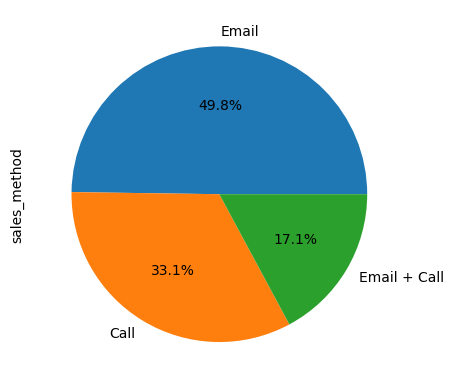

In [28]:
methods_abs = data['sales_method'].value_counts()
methods_prop = data['sales_method'].value_counts(normalize=True)
print(methods_abs)

methods_prop.plot(kind='pie', autopct='%1.1f%%')

According to the pie chart above, 7466, a bit under half of the customers were reached by email, followed by call with 4962 customers and 33.1% and the combined method with 2572 customers or 17.1%.

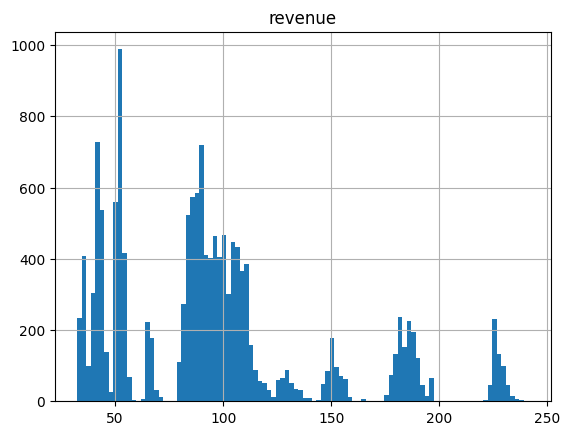

In [22]:
histogram = data.hist('revenue', bins=100)

The most significant share of the revenue spread is between 80-120 USD, but there is a notable spike around 50 to 60 USD too.

sales_method
Call            236402.76
Email           725688.88
Email + Call    473877.32
Name: revenue, dtype: float64


Text(0, 0.5, 'revenue')

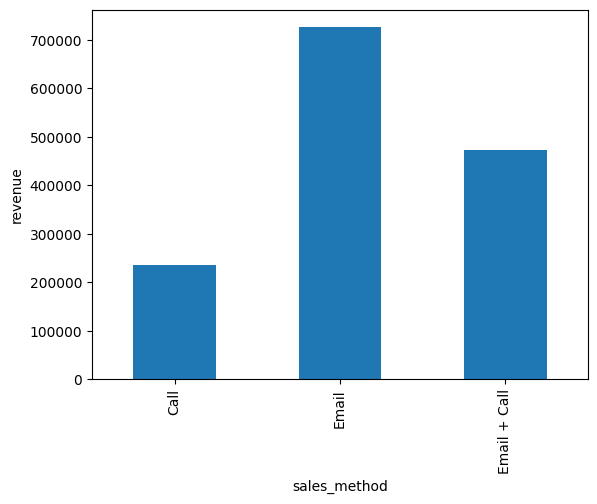

In [23]:
revenue_by_method = data.groupby('sales_method')['revenue'].sum()
print(revenue_by_method)

barplot = revenue_by_method.plot(kind='bar')
plt.ylabel('revenue')

The biggest share of revenue comes from the Email method with over 725688.88 USD, followed by the combined method (473877.32 USD) and then call (236402.76 USD).

week  sales_method
1     Call             26795.99
      Email           246239.33
      Email + Call     19116.37
2     Call             35120.58
      Email           148843.75
      Email + Call     30808.26
3     Call             37646.08
      Email           106843.84
      Email + Call     54013.39
4     Call             51689.81
      Email           117050.08
      Email + Call     89572.28
5     Call             55513.57
      Email            80914.65
      Email + Call    147718.47
6     Call             29636.73
      Email            25797.23
      Email + Call    132648.55
Name: revenue, dtype: float64


Text(0.5, 1.0, 'Revenue by week')

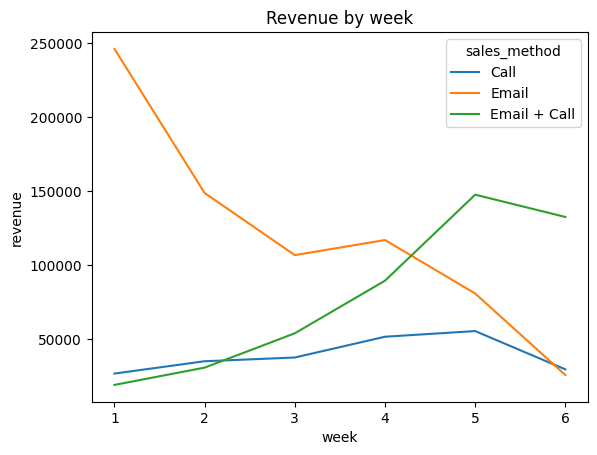

In [29]:
rev_overtime = data.groupby(['week', 'sales_method'])['revenue'].sum()
print(rev_overtime)

rev_overtime.unstack().plot()
plt.ylabel('revenue')
plt.title('Revenue by week')

The lineplot above shows that the Email method yields a very high revenue of 246239.33 USD in the first week after a product is launched, but shrinks heavily to 106843.84 USD until week 3, meaning a 56,6 % decrease. From that point on, the extra email in week 3 tends to give it a rebound of +9,5% until week 4, until it starts declining again steadily towards the week 6 number of 25797.23 USD. The revenue in the week 6 with the email method is only 10,5% compared to the first week's revenue with the same method.

The combined method of Email + Call starts with a marginal revenue of 19116.37 USD after the first week of the product launch, but increases to  30808.26 USD (+61 %), 54013.39 USD (+182 %), 89572.28 USD (+368 %) in week 2, 3 and 4 respectively, reaching the peak of 147718.47 USD (672 %) in week 5 and then decreasing around 10 % to 132648.55 USD in week 6. In summary, this method reaches the greatest revenue of them all in week 5 (even in week 6) and goes through a significant increase over time.

The Call method is relatively steady method, showing gradual increase from the 1st week's 26795.99 USD to 5th week's 55513.57 USD, indicating a revenue growth of 107 % in the period. The revenue sets back to 29636.73 USD (+10 % compared to week 1 and -46 % compared to week 5) in week six with this method. In conclusion, the peak revenue with this method is achieved in week 5, but the growth (or change in general) over time is very marginal compared to the two other methods.

week  sales_method
1     Call             35.350910
      Email            87.474007
      Email + Call    129.164662
2     Call             43.628050
      Email           100.164031
      Email + Call    154.041300
3     Call             41.736231
      Email            92.907687
      Email + Call    150.455125
4     Call             51.432647
      Email           108.883795
      Email + Call    180.954101
5     Call             53.173918
      Email           108.902624
      Email + Call    187.698183
6     Call             66.153415
      Email           130.950406
      Email + Call    227.527530
Name: revenue, dtype: float64


Text(0.5, 1.0, 'AVG revenue by customer')

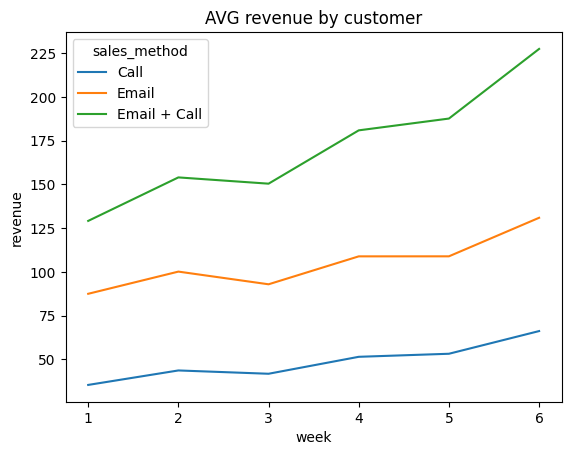

In [31]:
revenue_avgs = data.groupby(['week', 'sales_method'])['revenue'].mean()
print(revenue_avgs)

revenue_avgs.unstack().plot()
plt.ylabel('revenue')
plt.title('AVG revenue by customer')

If we look at the plot that shows the average revenue per customer, we can see that the highest average revenues are usually made with the combined method, followed by just email and then call. The difference of average revenue between Email and Call method is a pretty steady number of ~55 USD except for the last weeks' difference of 64 USD.

The combined method average seems to increase the gap between itself and the other methods overtime, starting with the difference of 42 USD (48% >) compared to Email, being 97 USD (74% >) in week 6 compared to email method again. This method clearly yields the highest revenues and has the highest increase within the same metric over time.

RECOMMENDATIONS:

Call method: Though around 1/3 of the customers were contacted with this method, it yields the lowest percentage of revenue and doesn't undergo a significant growth over time. Since it is also the most labor intensive, the client should consider ditching the whole method from its playbook and focus on the two others.

Email: This method is responsible for the greatest share of the net revenue and is used with almost half of the customers. It is a good method to sell new products right after launching, but the revenue decreases heavily until resending the email at week 3, curving the heavy decrease back up for another week. Based on this, I'd recommend you send emails on weekly basis from the launch date, instead of 3 weeks to keep the customers engaged throughout time.

Email + Call: This method is responsible for the biggest singluar sales, measured by revenue. Increasing both the number of emails and reaching the customers by call could significantly increase the company's total revenue, that's what I recommend you to do with the newly available resources after giving up the Call method.

BUSINESS METRICS TO FOLLOW

WEEKLY REVENUE BY METHOD: this metric is a good way to monitor which method produces the best results over time and allows the client to change between techniques when weekly revenues experience changes. Initial values:

week  sales_method
1     Email           246239.33
      Email + Call     19116.37
      
2     Email           148843.75
      Email + Call     30808.26
      
3     Email           106843.84
      Email + Call     54013.39
      
4     Email           117050.08
      Email + Call     89572.28
      
5     Email            80914.65
      Email + Call    147718.47
      
6     Email            25797.23
      Email + Call    132648.55

Within the Email method, the client should monitor if the recommendation of weekly emails stops the values from decreasing so heavily after the early weeks of the product launch and keeps it more horizontal. When the additional emails no longer keep the customers engaged, the salesstaff should start using the combined method of emails and calls, which tends to work in later weeks. The revenue of combined method should also increase now in the early stages when it is adopted more.


PROPORTION OF METHODS USED: Because the 'Email + Call' method has been proved to be very efficient, the client should follow wether its share in sales grows. The current share of the method is 17.1 %. It should grow significantly after dropping the inefficient 'Call' method, but also compete with the share of 'Email' method (49.8%)

SUMMARY

Updated methods: Dropping the 'Call' highly recommended. Emails should be sent more frequently, on a weekly basis. 'Email + Call' has best results and growth over time so its proportion should be increased as much as resources allow.

Metrics: Follow the revenue created by each method above to understand how they work over time. Current values can be found in cells above. Focus on timing: when one method (emails) starts to be inefficient over time, use the other technique more. Aim to increase the share of 'Email + Call' method overall (currently 17.1 %).

## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation